## Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA)
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [ ]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("/content/drive/MyDrive/ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [ ]:
def principalComponentAnalysis(X, numComponents):
    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """
    # Step 1: Flatten the images
    num_data, h, w = X.shape
    flattened_images = X.reshape(num_data, h*w)

    # Step 2: Compute the mean face
    mean_face = np.mean(flattened_images, axis=0)

    # Step 3: Subtract the mean face
    adjusted_images = flattened_images - mean_face

    # Step 3: Compute the covariance matrix on the transpose of the data matrix
    cov_matrix = np.dot(adjusted_images, adjusted_images.T) / num_data

    # Step 4: Find eigenvectors and eigenvalues of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # The eigenvectors of the covariance matrix of the original data are in the columns of eigenvectors matrix.
    # However, these are not the eigenfaces yet. We need to project them back to the original space.
    # Sort the eigenvectors by eigenvalues in descending order to get the principal components
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]

    # Select the top 'num_components' eigenvectors
    top_eigenvectors = eigenvectors[:, :numComponents]

    # Project the top eigenvectors back to the original space to get the eigenfaces
    eigenfaces = np.dot(adjusted_images.T, top_eigenvectors).T

    # Normalize the eigenfaces
    for i in range(eigenfaces.shape[0]):
        eigenfaces[i] = eigenfaces[i] / np.linalg.norm(eigenfaces[i])

    return mean_face, eigenfaces

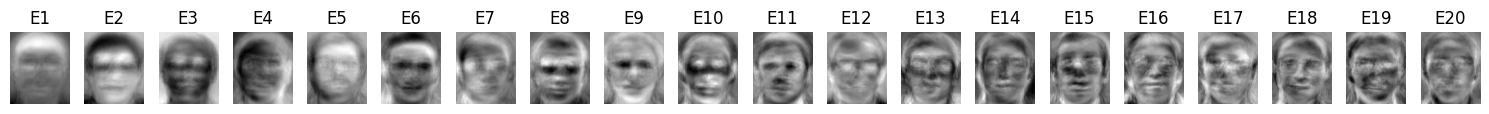

In [ ]:
# plot the eigen faces
%matplotlib inline

numComponents = 20
mean_face , eigenfaces = principalComponentAnalysis(trainFaces, numComponents)

num = 20 #number of faces to show
fig, axes = plt.subplots(1, num, figsize=(15, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i].reshape(112, 92), cmap='gray')  # Reshape each eigenface back to its original shape
    ax.set_title(f"E{i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### The plotted eigenfaces signify the principal components of the variation among the set of face images in the dataset. Each eigenface represents a mode of variation, capturing different features or aspects of how faces can vary from one another.

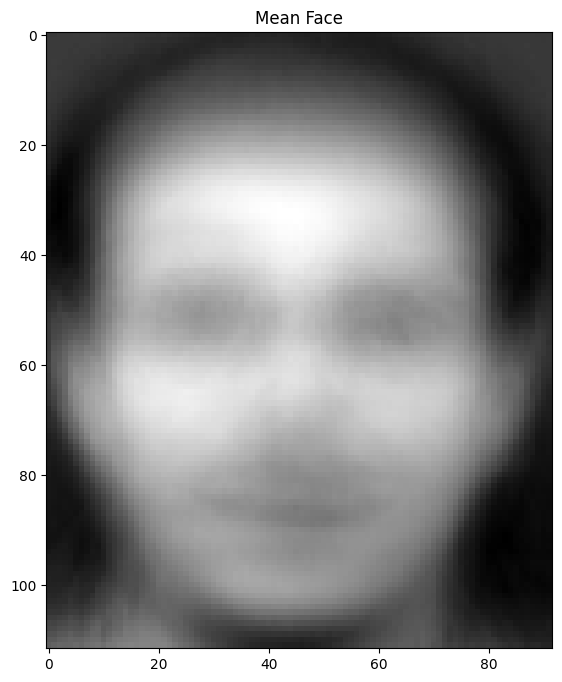

In [ ]:
# Plot the mean face
plt.figure(figsize=(8, 8))
plt.imshow(mean_face.reshape(112, 92), cmap='gray')  # Reshape the mean face back to its original shape
plt.title("Mean Face")
plt.show()

### The mean face is calculated by taking the pixel-wise average of all the images in the dataset. If your dataset consists of NN face images, and each image is represented as a vector of pixel intensities, the mean face is obtained by summing all these vectors and then dividing by NN. This results in a new vector (or image) where each pixel value is the average of that pixel across all images in the dataset.



```
# This is formatted as code
```

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [ ]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Helper function to reconstruct images
    """

    # Subtract the mean face
    meanAdjustedTestFace = testFace.flatten() - meanFace

    # Project onto the eigenfaces to get the weights
    weights = np.dot(meanAdjustedTestFace, eigenFaces.T)

    # Reconstruct the image using the weights
    reconstructedImage = meanFace + np.dot(weights, eigenFaces)

    return reconstructedImage.reshape(testFace.shape)

(112, 92)


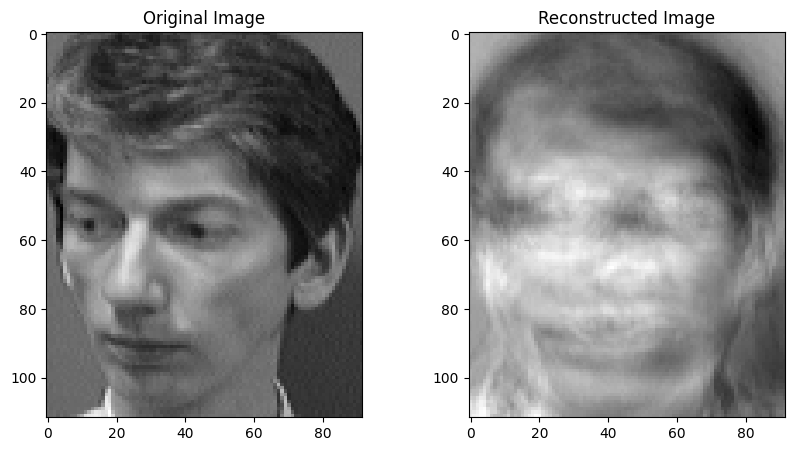

In [ ]:
# plot recontructions here
%matplotlib inline

testFace = testFaces[0]
print(testFace.shape)

reconstructedTestFace = imageReconstruction(testFace, eigenfaces, mean_face)

# Plotting the original and reconstructed image
plt.figure(figsize=(10, 5))
# Original image
plt.subplot(1, 2, 1)
plt.imshow(testFace, cmap='gray')
plt.title("Original Image")

# Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(reconstructedTestFace, cmap='gray')
plt.title("Reconstructed Image")

plt.show()

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

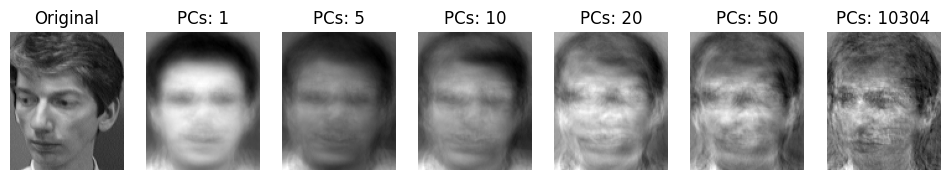

In [ ]:
%matplotlib inline

def displayNfactors(testFace,nFactorsList):
    flattenedTestFace = testFace.flatten()

    # Original image dimensions (for AT&T dataset)
    image_height, image_width = 112, 92

    # Plot original image
    plt.figure(figsize=(2 * len(nFactorsList), 4))
    plt.subplot(1, len(nFactorsList) + 1, 1)
    plt.imshow(testFace.reshape(image_height, image_width), cmap='gray')  # Use original dimensions directly
    plt.title("Original")
    plt.axis('off')

    for i, nFactors in enumerate(nFactorsList, start=2):
        # Use the first nFactors eigenFaces for reconstruction
        mean_face_full , eigenfaces_full = principalComponentAnalysis(trainFaces, nFactors)
        # Reconstruct the image
        reconstructedTestFace = imageReconstruction(flattenedTestFace, eigenfaces_full, mean_face_full)
        # Plot reconstructed image
        plt.subplot(1, len(nFactorsList) + 1, i)
        plt.imshow(reconstructedTestFace.reshape(image_height, image_width), cmap='gray')
        plt.title(f"PCs: {nFactors}")
        plt.axis('off')

    plt.show()

nFactorsList = [1, 5, 10, 20, 50, 10304]

displayNfactors(testFace, nFactorsList)


#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

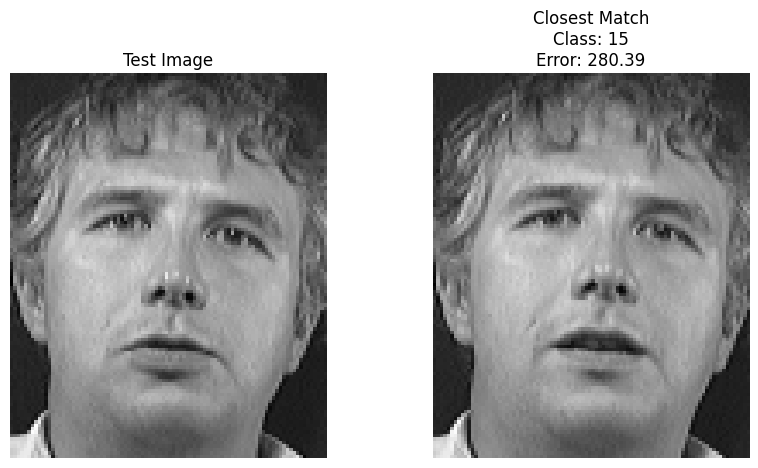

In [ ]:
from sklearn.metrics import mean_squared_error
def getClass(testImage, eigenFaces, meanFace, X_train, y_train):
    """
    Arguments:
    1. Test image
    2. Eigenvectors
    3. Mean Eigen Face
    4. Training Set(X_train,y_train)

    The function must return the following:
    1. image with smallest error
    2. error value
    3. prediction class
    """

    # Subtract the mean face from the test image
    meanAdjustedTestImage = testImage - meanFace

    # Project the mean-adjusted test image onto the eigenfaces
    testImageProjection = np.dot(meanAdjustedTestImage, eigenFaces.T)

    # Initialize minimum error to a large value and prediction to None
    minError = float('inf')
    prediction = 0
    closestImageIndex = None

    # Iterate over the training set
    for i, trainImage in enumerate(X_train):
        # Subtract the mean face from the training image
        meanAdjustedTrainImage = trainImage.flatten() - meanFace

        # Project the mean-adjusted training image onto the eigenfaces
        trainImageProjection = np.dot(meanAdjustedTrainImage, eigenFaces.T)

        # Calculate the Euclidean distance between the test image projection and the training image projection
        error = np.linalg.norm(testImageProjection - trainImageProjection)

        # Update the minimum error and prediction if this image is closer
        if error < minError:
            minError = error
            prediction = y_train[i]
            closestImageIndex = i

    # Retrieve the closest image from the training set
    closestImage = X_train[closestImageIndex].reshape(112,92)
    # print(prediction)
    return closestImage, minError, prediction

# Call the getClass function
testImage = testFaces[3].flatten()

closestImage, minError, prediction = getClass(testImage, eigenfaces, mean_face, trainFaces, trainLabels)
# print(prediction)

# Display the results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(testImage.reshape(112,92), cmap='gray')  # Reshape based on meanFace size
axes[0].set_title('Test Image')
axes[0].axis('off')

axes[1].imshow(closestImage, cmap='gray')
axes[1].set_title(f'Closest Match\nClass: {prediction}\nError: {minError:.2f}')
axes[1].axis('off')

plt.show()

Iterate through all the images in the test data and test the accuracy by taking different number of components

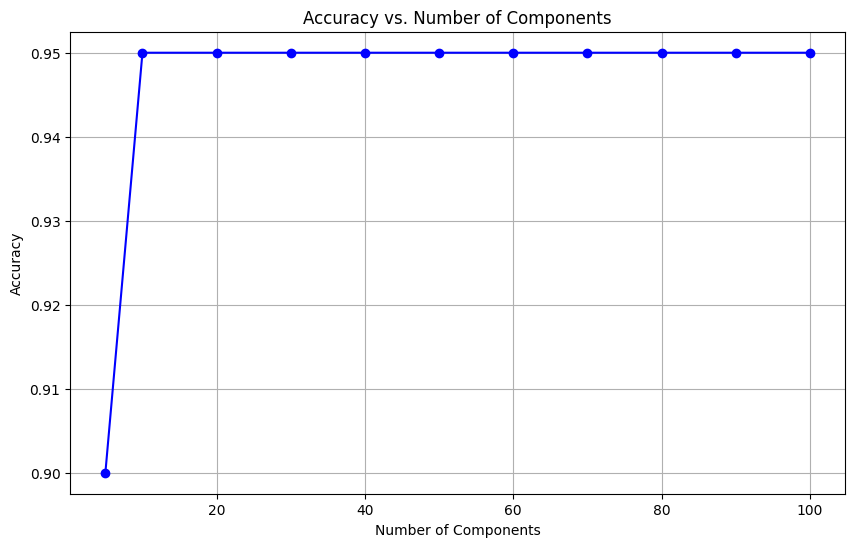

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = trainFaces,testFaces,trainLabels,testLabels

# Define the range of components to test
components_range = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Initialize a list to store accuracies
accuracies = []

for numComponents in components_range:
    # Compute PCA for the current number of components
    mean_face_n, eigenfaces_n = principalComponentAnalysis(X_train, numComponents)

    # Initialize a list to store predictions for the test set
    correct = 0
    total_image = len(X_test)

    for i in range(total_image):
        _, _, pred = getClass(X_test[i].flatten(), eigenfaces_n, mean_face_n, X_train, y_train)
        if pred == y_test[i]:
          correct+=1

    # Calculate and store the accuracy for the current number of components
    accuracy = correct/total_image
    accuracies.append(accuracy)

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(components_range, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Components')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
components = [3,5,10,20,30,40,50,60,70,80,90,100]
mse = []

for numComponents in components:
    # Select the top 'numComponents' eigenfaces
    mean_face , eigenfaces = principalComponentAnalysis(trainFaces, numComponents)

    totalMSE = 0  # To accumulate MSE for all test images
    for i in range(len(testFaces)):
        # Flatten the test image
        testImage = testFaces[i].flatten()

        # Reconstruct the test image using the selected eigenfaces

        reconstructedTestImage = imageReconstruction(testImage, eigenfaces, mean_face)

        # Calculate the MSE for the reconstructed image
        error = mean_squared_error(testImage,reconstructedTestImage)
        totalMSE += error

    # Calculate the average MSE for this number of components
    avgMSE = totalMSE / len(testFaces)
    mse.append(avgMSE)
    print(f"Components: {numComponents}, Average MSE: {avgMSE}")

Components: 3, Average MSE: 978.7758562259012
Components: 5, Average MSE: 807.4127207679032
Components: 10, Average MSE: 644.685579015077
Components: 20, Average MSE: 504.382231492898
Components: 30, Average MSE: 439.8636892894312
Components: 40, Average MSE: 401.258586353367
Components: 50, Average MSE: 373.02672097073895
Components: 60, Average MSE: 352.039209455736
Components: 70, Average MSE: 336.25869001059516
Components: 80, Average MSE: 324.4455724818523
Components: 90, Average MSE: 313.9458809087496
Components: 100, Average MSE: 304.68118234571386


##### After a certain point, the additional eigenvectors may correspond to very small eigenvalues, meaning they capture only a tiny fraction of the data's variance. The critical components that capture most of the variance are already included, so adding more components doesn't significantly improve the model's ability to reconstruct or differentiate the data.

Plot Number of eigenvectors vs Mean Square Error

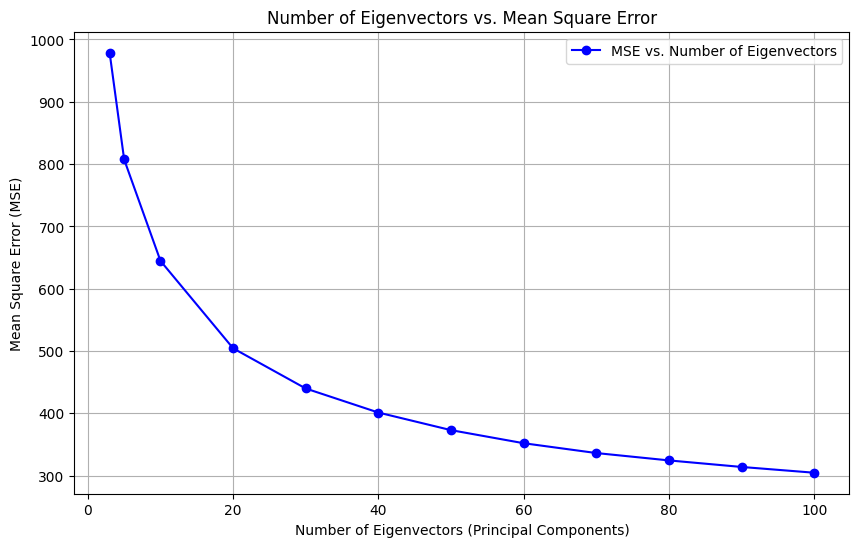

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(components, mse, '-o', color='blue', label='MSE vs. Number of Eigenvectors')
plt.xlabel('Number of Eigenvectors (Principal Components)')
plt.ylabel('Mean Square Error (MSE)')
plt.title('Number of Eigenvectors vs. Mean Square Error')
plt.grid(True)
plt.legend()
plt.show()

Plot Number of eigenvectors vs Logarithmic Mean Square Error

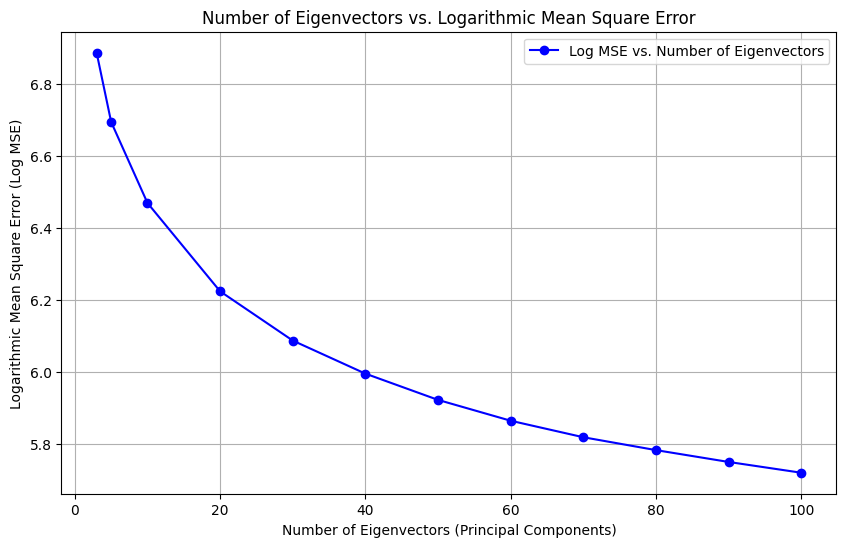

In [ ]:
log_mse = np.log(mse)
plt.figure(figsize=(10, 6))
plt.plot(components, log_mse, '-o', color='blue', label='Log MSE vs. Number of Eigenvectors')
plt.xlabel('Number of Eigenvectors (Principal Components)')
plt.ylabel('Logarithmic Mean Square Error (Log MSE)')
plt.title('Number of Eigenvectors vs. Logarithmic Mean Square Error')
plt.grid(True)
plt.legend()
plt.show()